##### Initialization: definition of robots and coordinates

In [1]:
import numpy as np
from UAV import *
import random
import matplotlib.pyplot as plt   


n_robots = 3#int(input("number of robots: "))
n_components = 2
platoon = []


# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

#TRUE COORDINATES [REALITY: THEY ARE UNKNOWN]
S = coordinates[0:2,:]

print(S)

[[0.         1.57388512 9.30355609]
 [0.         4.68034808 1.16543267]]


##### Definition of the (squared) distance matrix

In [2]:
DM2 = d_matrix2(platoon) #squared distance matrix -> for formulas
print(DM2)

#double check the distances
print('\n',DM2 - DM_from_S(S))

[[ 0.         24.38277254 87.9143892 ]
 [24.38277254  0.         72.10244355]
 [87.9143892  72.10244355  0.        ]]

 [[ 0.00000000e+00 -3.55271368e-15  0.00000000e+00]
 [-3.55271368e-15  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


##### S* estimation through EigenValue Decomposition

In [3]:
S_star = EVD(DM2,n_components)
print(S_star)

[[-3.07311544 -2.05443765  6.19044798]
 [ 2.36557134 -2.50129713  0.34422627]]


##### Removal of the ambiguity generated by distances in an Universal Euclidean transformation

In [4]:
#Translation removal
S_star = match_anchor(S,S_star,verbose=1)
print(S_star)

X displacement:  3.0731154357550703
Y displacement:  -2.365571339414136
Displacement matrix:
 [[ 3.07311544  3.07311544  3.07311544]
 [-2.36557134 -2.36557134 -2.36557134]]
[[ 0.          1.01867779  9.26356342]
 [ 0.         -4.86686847 -2.02134507]]


The new coordinates may be affected by rotation and flip ambiguities. Thus we must solve the problem with further analysis

##### Identification of rotation ambiguity

DM' : a new acquisition for the distances

We now introduce a displacement for the anchor, in order to build a new (squared) distance matrix.

In reality what we do is applying a displacement to the anchor and we get a new distance matrix

In [5]:
deltaX1 = 0.3
deltaY1 = 0.1

DeltaS_prime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime[:,0] = [deltaX1,deltaY1]

S_prime = S + DeltaS_prime
print(S_prime)

DM_prime = DM_from_S(S_prime,verbose=1)

[[0.3        1.57388512 9.30355609]
 [0.1        4.68034808 1.16543267]]
DM' :
 [[ 0.         22.60237185 82.19916901]
 [22.60237185  0.         72.10244355]
 [82.19916901 72.10244355  0.        ]]


Estimation of the rotation angle $\theta_r$

In [6]:
"""theta1a, theta1b = estimate_theta2(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=1,verbose=1)
print(theta1a)
print(theta1b)

theta2a, theta2b = estimate_theta2(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=2,verbose=1)
print(theta2a)
print(theta2b)"""

print("------------------------------------")
theta3a, theta3b = estimate_theta3(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=1,verbose=1)
print(theta3a)
print(theta3b)

theta4a, theta4b = estimate_theta3(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=2,verbose=1)
print(theta4a)
print(theta4b)

------------------------------------
1.0452841294241675
-0.8144429736963137
-0.7875981731686025
-1.2808205365335747


In [7]:
theta_r   = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],verbose=1)
theta_r_a = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],approx = 1,verbose=1)

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	0.724533
sin(theta):	-0.689240

Actual theta:	 -0.7604398896058016
Approx theta:	Disabled
Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	0.724533
sin(theta):	-0.689240

Actual theta:	 -0.7604398896058016
Approx theta:	 -0.7604


S** : estimated-rotated coordinates

In [8]:
S_star2 = rotateMatrix(theta_r)@S_star
S_star2a = rotateMatrix(theta_r_a)@S_star

##### Identification of flip ambiguity

We have to check if there is any flip ambiguity. To do so, we have to move the anchor one more time

In [9]:
deltaX2 = 0.7
deltaY2 = 0.4

DeltaS_prime2 = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime2[:,0] = [deltaX2,deltaY2]

S_prime2 = S + DeltaS_prime2
print(S_prime)

DM_prime2 = DM_from_S(S_prime2,verbose=1)

[[0.3        1.57388512 9.30355609]
 [0.1        4.68034808 1.16543267]]
DM' :
 [[ 0.         19.0850549  74.60706454]
 [19.0850549   0.         72.10244355]
 [74.60706454 72.10244355  0.        ]]


Now we estimate a second rotation angle $\theta_{r2}$: if = 0, no flip ambiguity

theta_r2 :  -0.0


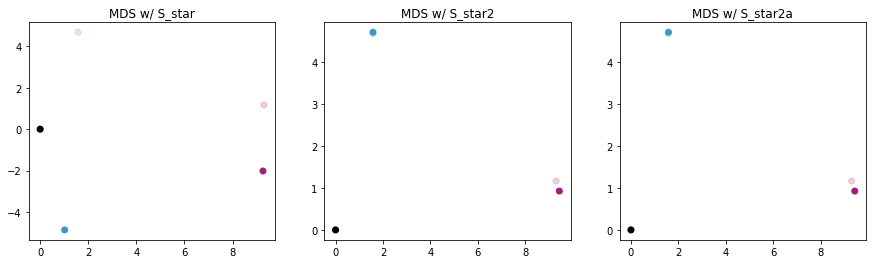

[[ 0.         -0.005665   -0.13257662]
 [ 0.         -0.03443023  0.23869508]]


In [11]:
theta_r2 = estimate_theta(DM2,DM_prime2,S_star2,[deltaX2,deltaY2],approx=2,verbose=0)
print("theta_r2 : ", theta_r2)


if (theta_r2 != 0):
  F = np.array([[-1,0],[0,1]])
    
  theta_r3 = estimate_theta(DM2,DM_prime,F@S_star,[deltaX1,deltaY1],verbose=0)
  theta_r3_a = estimate_theta(DM2,DM_prime,F@S_star,[deltaX1,deltaY1],approx=1,verbose=0)

  print("Wrong estimated angle:",theta_r)
  print("True  estimated angle:", theta_r3)

  S_star2 = rotateMatrix(theta_r3)@F@S_star
  S_star2a = rotateMatrix(theta_r3_a)@F@S_star


plot_points(S,S_star  = S_star,
              S_star2 = S_star2,
              S_star2a = S_star2a
            )
print(S-S_star2)